# Diffraction

Diffraction with circle aperture

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D   # this is for surface plots
from matplotlib import cm
%matplotlib inline

Opitical Parameters

All units are in SI!!!!

In [172]:
pupilcenter=(0,0,0)

focalcenter=(1,0,0)

lambdacenter=0.45e-6
lambdawide=0.15e-6
phi=np.pi*0


Useful TF functions

In [173]:
def ft2d(func):
    ft = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(func)))
    return ft

def ift2d(func):
    ift = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(func)))
    return ift

def ft1d_freq(x):
    """Calculate the (spatial) frequency array based on the spatial array x."""
    s = np.fft.fftshift(np.fft.fftfreq(x.size, d=x[-1]-x[-2]))
    return s

def zoom(im, x, y, bb):
    """Cut out a square box from image im centered on (x,y) with half-box size bb."""
    return(im[y-bb:y+bb,x-bb:x+bb])

def padcplx(c, pad=5):
    """Puts a Complex array in the centre of a zero-filled Complex array.
    pad defines the padding multiplier for the output array."""
    (nx, ny) = c.shape
    bignx = nx * pad + 1
    bigny = ny * pad + 1
    big_c = np.zeros((bignx, bigny), dtype=complex)
    
    dx = int((nx * (pad-1)) / 2 + 1)
    dy = int((ny * (pad-1)) / 2 + 1)
    
    big_c[dx:dx+nx,dy:dy+ny] = c
    return(big_c)

#Grids
npix = 500
pad = 5
npix_pad = npix*pad+1   # figure out the padded big array sizes after the FT

Pupile plan

In [174]:
# Define a function for a circular aperture
def circle_mask(im, xc, yc, rcirc):
    """Create a circular aperture centered on (xc, yc) with radius rcirc."""
    x, y = np.shape(im)
    newy, newx = np.mgrid[:y,:x]
    circ = (newx-xc)**2 + (newy-yc)**2 < rcirc**2
    return circ.astype('float')

rad = 0.7 * npix/2   # radius in pixels of the circular aperture

#Tip-Tilt phase
lin = np.linspace(-0.5, 0.5, npix)
xx, yy = np.meshgrid(lin, lin)

aperture = circle_mask(xx, int(npix/2), int(npix/2), rad)
aperture=aperture*np.exp(1j*(xx+yy+phi))

Focal plan

1 TF aperture

2 Make coronaph aperture

3 Multiply TF and coronagraph

In [175]:

focalplan_BC = ft2d(padcplx(aperture))

"""
CLC=1-circle_mask(focalplan_BC, int(npix/2), int(npix/2), rad/2)

focalplan_AC=focalplan_BC*CLC
"""

'\nCLC=1-circle_mask(focalplan_BC, int(npix/2), int(npix/2), rad/2)\n\nfocalplan_AC=focalplan_BC*CLC\n'

LyotStop plan

1 TF focal pla after Conagraph

2 Make (Lyotstop) aperture

3 Multiply TF and (Lyotstop) aperture

In [176]:
"""B_Lyot = ft2d(padcplx(focalplan_AC))
Lyot=circle_mask(B_Lyot, int(npix/2), int(npix/2), rad/2)
A_Lyot=B_Lyot*Lyot

plt.imshow(np.abs(B_Lyot)**2)
plt.colorbar()
plt.title('Pupil plan - Intensity')
"""

"B_Lyot = ft2d(padcplx(focalplan_AC))\nLyot=circle_mask(B_Lyot, int(npix/2), int(npix/2), rad/2)\nA_Lyot=B_Lyot*Lyot\n\nplt.imshow(np.abs(B_Lyot)**2)\nplt.colorbar()\nplt.title('Pupil plan - Intensity')\n"

Text(0.5, 1.0, 'Focal plan BC - phase')

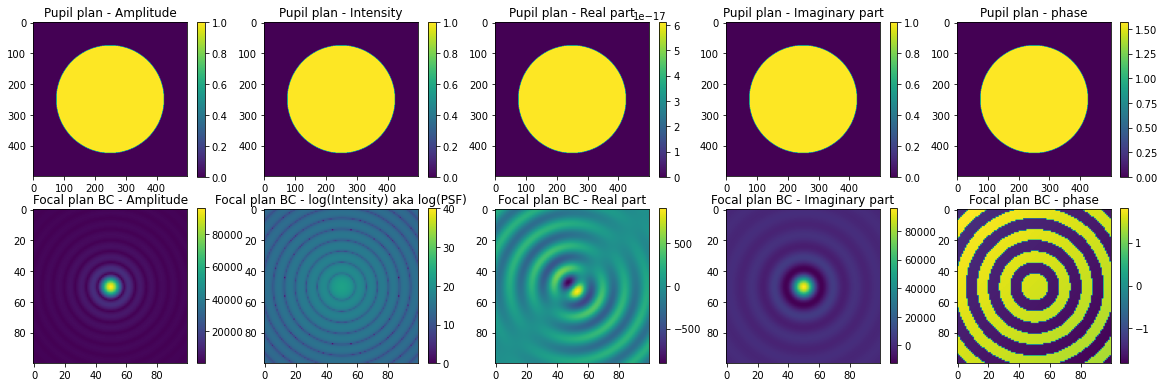

In [177]:
# Ploting Cells
zoomfac = 50     # half-size of the zoom box will be 1/zoomfac of total image
box = int(npix_pad/zoomfac)

#Name=[Pupil plan, Focal plan before coronagraph, Focal plan after coronagraph, Before Lyot-Stop, After Lyot-Stop, Screen]
#Object=[aperture, focalplan_BC, focalplan_AC, B_Lyot, A_Lyot, screen]

# This is a smaller data array wiht our region of interest.
focalplan_BC_zoom = zoom(focalplan_BC, int(npix_pad/2), int(npix_pad/2), box)
plt.figure(figsize=(20, 20))

#for i in range(1)
plt.subplot(6, 5, 1)
plt.imshow(np.abs(aperture))
plt.colorbar()
plt.title('Pupil plan - Amplitude')

plt.subplot(6, 5, 2)
plt.imshow(np.abs(aperture)**2)
plt.colorbar()
plt.title('Pupil plan - Intensity')

plt.subplot(6, 5, 3)
plt.imshow(np.real(aperture))
plt.colorbar()
plt.title('Pupil plan - Real part')

plt.subplot(6, 5, 4)
plt.imshow(np.imag(aperture))
plt.colorbar()
plt.title('Pupil plan - Imaginary part')

plt.subplot(6, 5, 5)
plt.imshow(np.angle(aperture))
plt.colorbar()
plt.title('Pupil plan - phase')
  
plt.subplot(6, 5, 6)
plt.imshow(np.abs(focalplan_BC_zoom))
plt.colorbar()
plt.title('Focal plan BC - Amplitude')

plt.subplot(6, 5, 7)
plt.imshow(np.log(np.abs(focalplan_BC_zoom)**2))
plt.colorbar()
plt.clim(0, 40)
plt.title('Focal plan BC - log(Intensity) aka log(PSF)')

plt.subplot(6, 5, 8)
plt.imshow(np.real(focalplan_BC_zoom))
plt.colorbar()
plt.title('Focal plan BC - Real part')

plt.subplot(6, 5, 9)
plt.imshow(np.imag(focalplan_BC_zoom))
plt.colorbar()
plt.title('Focal plan BC - Imaginary part')

plt.subplot(6, 5, 10)
plt.imshow(np.angle(focalplan_BC_zoom))
plt.colorbar()
plt.title('Focal plan BC - phase')



In [ ]:
"""
plt.subplot(6, 5, 11)
plt.imshow(np.log(np.abs(B_Lyot)))
plt.colorbar()
plt.clim(0, 40)
plt.title('Before Lyot plan - Amplitude')

plt.subplot(6, 5, 12)
plt.imshow(np.log(np.abs(B_Lyot)**2))
plt.colorbar()
plt.clim(0, 40)
plt.title('Before Lyot plan - log(Intensity) aka log(PSF)')

plt.subplot(6, 5, 13)
plt.imshow(np.real(B_Lyot))
plt.colorbar()
plt.title('Before Lyot plan - Real part')

plt.subplot(6, 5, 14)
plt.imshow(np.imag(B_Lyot))
plt.colorbar()
plt.title('Before Lyot plan - Imaginary part')

plt.subplot(6, 5, 15)
plt.imshow(np.angle(B_Lyot))
plt.colorbar()
plt.title('Before Lyot plan - phase')
"""